# A simple example

To illustrate the application of quantile regression neural networks we consider a simple, 1-dimensional regression probelm with heteroscedastic uncertainty:

\begin{align}
y = \sin(x) + \cos(x) \cdot \mathcal{N}(0, 1)
\end{align}

The code below generates the synthetic training data consisting of $10^7$ randomly sampled $x$ values and corresponding $y$ values.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import quantnn
import quantnn.plotting
quantnn.plotting.set_style()


Bad key "mathtext.fallback" on line 203 in
/home/simonpf/src/quantnn/quantnn/data/matplotlib_style.rc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


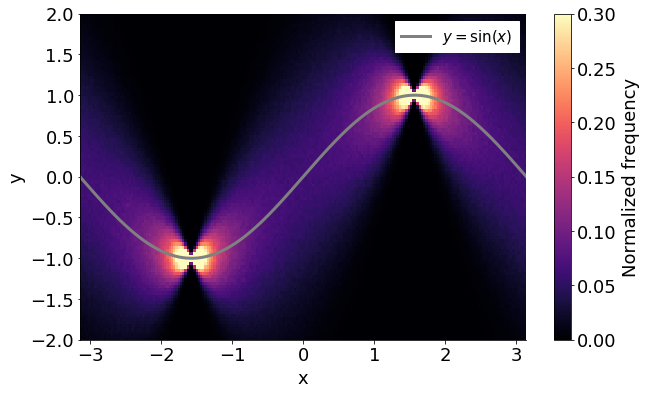

In [2]:
from quantnn.examples import simple
x, y = simple.create_training_data(10_000_000)
simple.plot_histogram(x, y)
plt.savefig("simple_training_data.png")

## Quantile regression neural networks (QRNNs)

The task of predicting the conditional distribution $P(y|x)$ of $y$ given input $x$ can be solved using quantile regression. The ``QRNN`` class of the quantnn package provides an implementation of a Quantile Regression Neural Network (QRNN), i.e. it uses a neural network to learn to predict the quantiles of the posterior distribution $P(y|x)$.


### Model definition and training

The simplest way to train a quantile regression neural network is to use the ``quantnn.QRNN`` class, which provides a simple interface to define and and train QRNNs based on fully-connected, feed-forward neural networks.

To do this all we need to do is to choose which quantiles to predict as well as the basic parameters of the network architecture. More specifically, the following information must be provided to the constructor of the ``QRNN`` class:

1. The list of quantiles that we want to predict.
2. The number of input features (``input_dimensions``). For this simple example this just ``1``.
3. A tuple describing the model architecture ``(n_layers, n_neurons, activation_function)``

> **Note:** quantnn will automatically choose the backend between Keras and PyTorch depending on which one is available on your system. You can specifically choose one over the other using the ``quantnn.qrnn.set_backend`` function.

In [3]:
import quantnn as q
quantiles = np.linspace(0.01, 0.99, 99)

layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
qrnn = q.QRNN(quantiles, n_inputs=1, model=model)

Finally, we train the neural network on the training data. Here, we use only a subset of the data, in order to speed up the training process. We restart the training three times while lowering the learning rate, which leads to more accurate predicted quantiles.

In [5]:
training_data = (x[::5].reshape(-1, 1), y[::5].reshape(-1, 1))
results = qrnn.train(training_data=training_data,
                     n_epochs=15)

Output()

                                                                                          
                                                                                          
                                     Training history                                     
                                                                                          
                 Epoch                                    Training loss                   
──────────────────────────────────────────────────────────────────────────────────────────
         #                  LR

  1               0.010                                0.183

Output()

  2               0.010                                0.183

Output()

  3               0.010                                0.183

Output()

  4               0.010                                0.183

Output()

  5               0.010                                0.183

Output()

  6               0.010                                0.183

Output()

  7               0.010                                0.183

Output()

  8               0.010                                0.183

Output()

  9               0.010                                0.183

Output()

 10               0.010                                0.182

Output()

 11               0.010                                0.182

Output()

 12               0.010                                0.183

Output()

 13               0.010                                0.183

Output()

 14               0.010                                0.182

Output()

 15               0.010                                0.183

Exception ignored in: <function TrainingLogger.__del__ at 0x7fa09c0b99e0>
TypeError: __del__() takes 0 positional arguments but 1 was given


### Evaluation

To evaluate the QRNN we generate 1000 new $x$-value and use the ``predict`` method of the trained ``qrnn`` object to predict the quantiles of $y$.

In [ ]:
n = 1_000
x_val = np.linspace(-np.pi, np.pi, n)
y_val = simple.create_validation_data(x_val)
y_pred = qrnn.predict(x_val.reshape(-1, 1))
y_mean = q.posterior_mean(y_pred, qrnn.quantiles)

We can now compare the quantiles predicted using the QRNN to the empirical quantiles from the training data. The QRNN manages fairly well to predict the true conditional cumulative distribution function (CDF). With additional optimization of the training process, the 

In [ ]:
from quantnn.plotting import plot_quantiles
from matplotlib.gridspec import GridSpec

gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.05])
f = plt.figure(figsize=(12, 5))

# Calculate empirical CDF
bins = np.linspace(-np.pi, np.pi, 201)
counts, _, _ = np.histogram2d(y, x, bins=bins)
norm = np.sum(counts * (bins[1:] - bins[:-1]), axis=0, keepdims=True)
counts /= norm
cdf = np.cumsum(counts * (bins[1:] - bins[:-1]), axis=0)

# Plot QRNN quantiles
ax = plt.subplot(gs[0, 0])
m = plot_quantiles(ax, x_val, y_pred[:, 1::6], qrnn.quantiles[1::6])
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("(a) Predicted CDF", loc="left")
ax.grid(False)

# Plot true cdf
ax = plt.subplot(gs[0, 1])
ax.pcolormesh(bins, bins, cdf, cmap=m.cmap, norm=m.norm)
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel("x")
ax.set_title("(b) True CDF", loc="left")

ax = plt.subplot(gs[0, 2])
plt.colorbar(m, cax=ax, label="$P(Y \leq y | X=x)$")
plt.tight_layout()

## Density regression neural network

An alternative way to learn to predict the distribution $P(y|x)$ is to use a neural network to predict a gridded approximation of the probability density function, a technique we will, for simplicity, refer to as Density Regression Neural Network (DRNN).

To create a DRNN model, we need to choose a suitable binning for the output value. Here we simply use an equidistant grid covering the range $-3$ to $3$. Apart from having to provide the bins of the output PDF instead of the quantiles to predict, the definition, training and evaluation of the DRNN works in exactly the same way as for the QRNN.

In [ ]:
from quantnn.drnn import DRNN
layers = 4
neurons = 128
activation = "relu"
model = (layers, neurons, activation)
bins = np.linspace(-3, 3, 101)
drnn = DRNN(bins, input_dimensions=1, model=model)

In [ ]:
training_data = (x[::5].reshape(-1, 1), y[::5].reshape(-1, 1))
results = drnn.train(training_data=training_data,
           n_epochs=15)

In [ ]:
y_pred = drnn.predict(x_val.reshape(-1, 1))

To evaluate the quality of the predicted PDF, we can now simply plot the predicted PDFs to the empirical PDFs of the training data. Similar as for the QRNN, the prediction match the reference values fairly well.

In [ ]:
from quantnn.plotting import plot_quantiles
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.05])
f = plt.figure(figsize=(12, 5))
norm=Normalize(0.0, 0.5)

# Plot DRNN PDF
bin_centers = 0.5 * (drnn.bins[1:] + drnn.bins[:-1])
ax = plt.subplot(gs[0, 0])
m = ax.pcolormesh(x_val, bin_centers, y_pred.T, norm=norm)
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("(a) Predicted PDF", loc="left")
ax.grid(False)

# Plot true cdf
bins_x = np.linspace(-np.pi, np.pi, 201)
counts, _, _ = np.histogram2d(y, x, bins=((bins, bins_x)))
counts /= np.sum(counts * (bins[1:] - bins[:-1])[:, np.newaxis], axis=0, keepdims=True)

ax = plt.subplot(gs[0, 1])
ax.pcolormesh(bins_x, bins, counts, norm=norm)
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel("x")
ax.set_title("(b) True PDF", loc="left")

ax = plt.subplot(gs[0, 2])
plt.colorbar(m, cax=ax, label="$p(y | x)$")
plt.tight_layout()

## Calculating posterior statistics 

Both the QRNN and DRNN allow us to predict the posterior distribution of the quantity $y$ given input $x$. In most applications, however, we are not interested in the full distribution but rather specific statistics. The quantnn package provides functions to calculate a range of such statistics in the ``quantnn.quantiles`` module for QRNN predictions and in the ``quantnn.desntiy`` module for predictions produced by a DRNN.

In [ ]:
y_pred_qrnn = qrnn.predict(x_val.reshape(-1, 1))
y_pred_drnn = drnn.predict(x_val.reshape(-1, 1))

### Mean and median

In [ ]:
import quantnn.quantiles as qq
import quantnn.density as qd

qrnn_mean = qq.posterior_mean(y_pred_qrnn, qrnn.quantiles)
drnn_mean = qd.posterior_mean(y_pred_drnn, drnn.bins)
qrnn_median = qq.posterior_median(y_pred_qrnn, qrnn.quantiles)
drnn_median = qd.posterior_median(y_pred_drnn, drnn.bins)

In [ ]:
gs = GridSpec(2, 2, height_ratios=[1.0, 0.1])
f, axs = plt.subplots(1, 2, figsize=(12, 5))
y_mean = np.sin(x_val)

ax = plt.subplot(gs[0, 0])
ax.plot(x_val, qrnn_mean)
ax.plot(x_val, drnn_mean)
ax.plot(x_val, y_mean, c="k", ls="--", label="Truth")
ax.set_title("(a) Mean", loc="left")

ax = plt.subplot(gs[0, 1])
handles = []
handles += ax.plot(x_val, qrnn_median)
handles += ax.plot(x_val, drnn_median)
handles += ax.plot(x_val, y_mean, c="k", ls="--", label="Truth")
ax.set_title("(b) Median", loc="left")

ax = plt.subplot(gs[1, :])
ax.set_axis_off()
ax.legend(handles=handles, labels=["QRNN", "DRNN", "truth"], ncol=3, loc="center")

### Quantiles

In [ ]:
quantiles = np.linspace(0.1, 0.9, 9)
quantiles_qrnn = qq.posterior_quantiles(y_pred_qrnn, qrnn.quantiles, quantiles)
quantiles_drnn = qd.posterior_quantiles(y_pred_drnn, drnn.bins, quantiles)

In [ ]:
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.05])
f, axs = plt.subplots(1, 2, figsize=(13, 5))
y_mean = np.sin(x_val)

ax = plt.subplot(gs[0, 0])
m = plot_quantiles(ax, x_val, quantiles_qrnn, quantiles)
ax.set_title("(a) QRNN quantiles", loc="left")
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-2, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = plt.subplot(gs[0, 1])
plot_quantiles(ax, x_val, quantiles_drnn, quantiles)
ax.set_title("(b) DRNN quantiles", loc="left")
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-2, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = plt.subplot(gs[0, 2])
plt.colorbar(m, cax=ax, label="$P(Y \leq y | X=x)$")

## Binned PDF

In [ ]:
bins = drnn.bins
centers = 0.5 * (bins[1:] + bins[:-1])
binned_pdf_qrnn = qq.pdf_binned(y_pred_qrnn, qrnn.quantiles, bins)

In [ ]:
gs = GridSpec(1, 3, width_ratios=[1.0, 1.0, 0.05])
f, axs = plt.subplots(1, 2, figsize=(13, 5))
norm = Normalize(0, 0.5)

ax = plt.subplot(gs[0, 0])
m = ax.pcolormesh(x_val, centers, binned_pdf_qrnn.T, norm=norm)
ax.set_title("(a) QRNN", loc="left")
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-2, 2])
ax.set_xlabel("x")
ax.set_ylabel("y")

ax = plt.subplot(gs[0, 1])
m = ax.pcolormesh(x_val, centers, y_pred_drnn.T, norm=norm)
ax.set_title("(b) DRNN", loc="left")
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([-2, 2])
ax.set_xlabel("x")

ax = plt.subplot(gs[0, 2])
plt.colorbar(m, cax=ax, label="$p(y | x)$")
plt.tight_layout()

## Classification

Finally, we consider the case of trying to classfying whether the output $y$ corresponding to a  given $x$ is larger than a certain threshold value. For this we can use the ``probability_larger_than`` functions of the ``quantnn.quantiles`` and ``quantnn.density`` modules. This function returns the probability that the output $y$ is larger than the given threshold.

In [ ]:
t = 0.1
p_qrnn = qq.probability_larger_than(y_pred_qrnn, qrnn.quantiles, t)
p_drnn = qd.probability_larger_than(y_pred_drnn, drnn.bins, t)

# Calculate empirical probability
bins = np.linspace(-np.pi, np.pi, 201)
counts, _, _ = np.histogram2d(y, x, bins=bins)
centers = 0.5 * (bins[1:] + bins[:-1])
counts_larger_t = counts * (centers > t).reshape(-1, 1)
p = np.sum(counts_larger_t, axis=0) / np.sum(counts, axis=0)

In [ ]:
f, ax = plt.subplots(1, 1)
ax.plot(x_val, p_qrnn)
ax.plot(x_val, p_drnn)
ax.plot(centers, p, c="k", ls="--")
ax.set_xlim([-np.pi, np.pi])
ax.set_ylim([0, 1])
ax.set_xlabel("x")
ax.set_ylabel("$P(Y > 0.1 | X = x)$")